In [ ]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from src.utils import get_config, get_data

config = get_config()

In [3]:
ftse100 = get_data('ftse100')
ftsemib = get_data('ftsemib')
sp500 = get_data('s&p500')
ssec = get_data('ssec')

## SandBox

In [172]:
import numpy as np
import pandas as pd
from scipy.stats import linregress

def calculate_hurst(prices, window_size=250, sub_window=10):
    returns = np.log(prices[1:]) - np.log(prices[:-1])
    
    hurst_values = []
    ineff_values = []
    
    for i in range(len(returns) - window_size):
        window = returns[i:i+window_size]
        vol = []
        for j in range(0, window_size, sub_window):
            if j + sub_window > len(window):
                break
            sub_window_data = window[j:j+sub_window]
            vol.append(np.std(sub_window_data))
        if not vol:
            avg_vol = 0
        else:
            avg_vol = np.mean(vol)
        
        log_size = np.log10(sub_window)
        log_vol = np.log10(avg_vol)
        
        slope = 0.0
        if len(vol) > 1:
            slope, _, _, _, _ = linregress([log_size]*len(vol), [log_vol]*len(vol))
        
        hurst = slope
        hurst_values.append(hurst)
        ineff_values.append(0.5 - hurst)
    
    return hurst_values, ineff_values

# Charger les données
prices = get_data('s&p500')

# Calculer les indices de Hurst et l'inefficacité
hurst_values, ineff_values = calculate_hurst(prices)

# Créer des séries temporelles
hurst_series = pd.Series(hurst_values, index=prices[250:].index)
ineff_series = pd.Series(ineff_values, index=prices[250:].index)

# Visualiser les résultats
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(hurst_series, label='Hurst Exponent')
plt.axhline(y=0.5, color='r', linestyle='--', label='Efficient Market (H=0.5)')
plt.title('Hurst Exponent Over Time')
plt.xlabel('Date')
plt.ylabel('Hurst Exponent')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(ineff_series, label='Market Inefficiency')
plt.title('Market Inefficiency Over Time')
plt.xlabel('Date')
plt.ylabel('Inefficiency Measure')
plt.legend()
plt.show()

/var/folders/vk/z0p4r5z97d99dp7mpbt9yd1w0000gn/T/ipykernel_75230/3116201202.py:25: RuntimeWarning: divide by zero encountered in log10
  log_vol = np.log10(avg_vol)


ValueError: Cannot calculate a linear regression if all x values are identical

In [149]:
hurst_series

Date
1984-12-27 00:00:00+00:00   NaN
1984-12-28 00:00:00+00:00   NaN
1984-12-31 00:00:00+00:00   NaN
1985-01-02 00:00:00+00:00   NaN
1985-01-03 00:00:00+00:00   NaN
                             ..
2025-03-24 00:00:00+00:00   NaN
2025-03-25 00:00:00+00:00   NaN
2025-03-26 00:00:00+00:00   NaN
2025-03-27 00:00:00+00:00   NaN
2025-03-28 00:00:00+00:00   NaN
Length: 10168, dtype: float64

In [9]:
import numpy as np
import pandas as pd

def compute_hurst(prices, k=10):
    """
    Calculate time-varying Hurst exponent using variance method
    Parameters:
        prices: array-like, price series
        k: int, window size (default=10 days as per paper)
    Returns:
        array of Hurst exponents
    """
    # Calculate log returns
    returns = np.log(prices[1:]) - np.log(prices[:-1])
    
    # Initialize arrays
    hurst_series = []
    
    for t in range(len(returns) - k):
        window = returns[t:t+k]
        # Calculate variances at different scales
        scales = range(2, k//2)
        variances = []
        scales_log = []
        
        for scale in scales:
            # Subdivide window into scale-sized segments
            segments = len(window) // scale
            if segments > 0:
                variance = np.std([np.std(window[i:i+scale]) 
                                 for i in range(0, len(window), scale)])
                variances.append(np.log(variance))
                scales_log.append(np.log(scale))
        
        if len(scales_log) > 1:
            # Perform log-log regression
            slope, _ = np.polyfit(scales_log, variances, 1)
            hurst = slope  # Hurst exponent is the slope
            hurst_series.append(hurst)
        else:
            hurst_series.append(np.nan)
    
    return np.array(hurst_series)

def compute_hurst_series(prices: pd.Series, k: int = 10) -> pd.Series:
    """
    Calcule l'exposant de Hurst variable dans le temps en utilisant la méthode de la variance.
    
    Paramètres:
        prices: pd.Series, série de prix avec un index temporel
        k: int, taille de la fenêtre (par défaut 10)
        
    Retourne:
        pd.Series contenant l'exposant de Hurst, indexé par la date correspondant 
        à la fin de chaque fenêtre.
    """
    # Calcul des rendements logarithmiques
    log_prices = np.log(prices)
    returns = log_prices.diff().dropna()
    
    hurst_values = []
    indices = []
    
    # Boucle sur les fenêtres de taille k dans les rendements
    for t in range(len(returns) - k):
        window = returns.iloc[t:t+k].values
        scales = range(2, k // 2)
        variances = []
        scales_log = []
        
        # Pour chaque échelle, subdiviser la fenêtre et calculer la variance des std
        for scale in scales:
            segments = len(window) // scale
            if segments > 0:
                sub_stds = [np.std(window[i:i+scale]) for i in range(0, len(window), scale)]
                variance = np.std(sub_stds)
                variances.append(np.log(variance))
                scales_log.append(np.log(scale))
        
        # Régression log-log pour déterminer la pente (exposant de Hurst)
        if len(scales_log) > 1:
            slope, _ = np.polyfit(scales_log, variances, 1)
            hurst = slope
        else:
            hurst = np.nan
        
        hurst_values.append(hurst)
        # Utiliser le timestamp du dernier élément de la fenêtre
        indices.append(returns.index[t+k-1])
    
    return pd.Series(hurst_values, index=indices)

In [166]:
def hurst(log_prices, scales):
    """
    Calculate the Hurst exponent using the variance method.
    Parameters:
        log_prices: array-like, log prices
        scales: array-like, scales to compute the Hurst exponent
    Returns:
        float, Hurst exponent
    """
    # Calculate the log returns
    variances = []
    for scale in scales:
        scaled_series = np.subtract(log_prices[scale:], log_prices[:-scale])
        variances.append(np.std(scaled_series))
    m = np.polyfit(np.log10(scales), np.log10(variances), 1)
    return m[0]
import numpy as np
import pandas as pd

def compute_hurst_series(prices: pd.Series, k: int = 100) -> pd.Series:
    """
    Calcule la série de l'exposant de Hurst en utilisant une fenêtre glissante de taille k.
    
    Paramètres:
        prices: pd.Series, série de prix avec un index temporel.
        k: int, taille de la fenêtre pour le calcul (par défaut 10).
    
    Retourne:
        pd.Series contenant les exposants de Hurst, indexée par la date correspondant à la fin de chaque fenêtre.
    """
    # Convertir les prix en logarithme
    log_prices = np.log(prices)
    hurst_values = []
    indices = []
    
    # Définir les échelles à utiliser (par exemple de 2 à k//2 inclus)
    scales = range(2, k // 2)
    
    # Calcul sur chaque fenêtre glissante
    for i in range(len(log_prices) - k + 1):
        window = log_prices.iloc[i:i+k].values
        hurst_val = hurst(window, scales)
        hurst_values.append(hurst_val)
        # Utiliser le timestamp du dernier élément de la fenêtre
        indices.append(log_prices.index[i+k-1])
    
    return pd.Series(hurst_values, index=indices)

<Axes: >

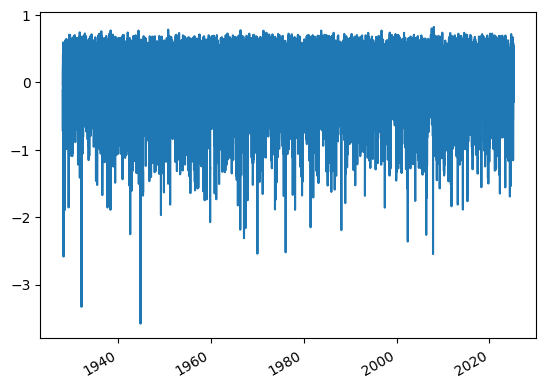

In [171]:
result = compute_hurst_series(sp500, k=10)
result.describe()
result.plot()

In [153]:
result

NameError: name 'result' is not defined

In [169]:
ftse100

Date
1984-01-03 00:00:00+00:00     997.500000
1984-01-04 00:00:00+00:00     998.599976
1984-01-05 00:00:00+00:00    1015.799988
1984-01-06 00:00:00+00:00    1029.000000
1984-01-09 00:00:00+00:00    1034.599976
                                ...     
2025-03-24 00:00:00+00:00    8638.000000
2025-03-25 00:00:00+00:00    8663.799805
2025-03-26 00:00:00+00:00    8689.599609
2025-03-27 00:00:00+00:00    8666.099609
2025-03-28 00:00:00+00:00    8658.900391
Name: ftse100, Length: 10418, dtype: float64

<Axes: title={'center': 'Hurst exponent FTSE100'}>

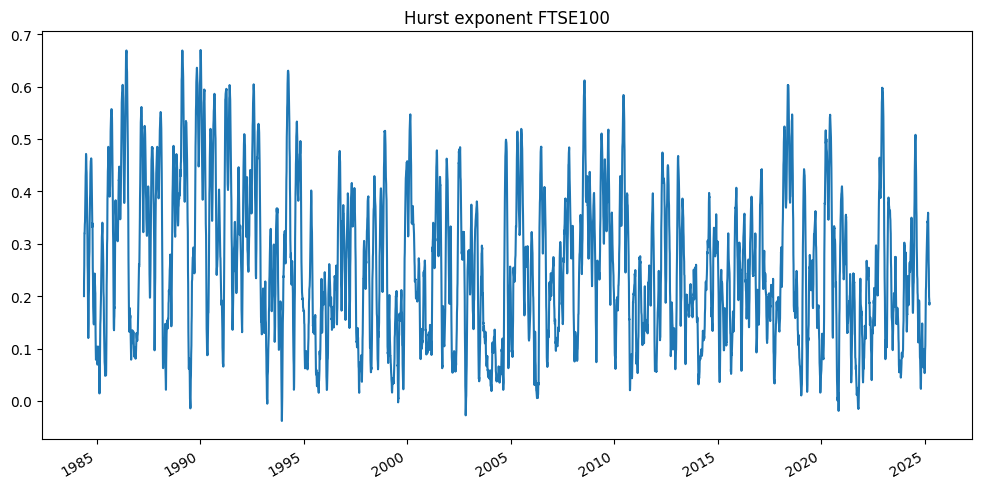

In [146]:
compute_hurst_series(ftse100).plot(title='Hurst exponent FTSE100', figsize=(12, 6))

In [ ]:
import numpy as np
from scipy import stats

def calculate_hurst(prices, min_window=10, max_window=None):
    # Convert prices to returns if needed
    returns = np.log(prices[1:]) - np.log(prices[:-1])
    
    if max_window is None:
        max_window = len(returns) // 2
    
    # Create range of window sizes
    window_sizes = np.logspace(np.log10(min_window), 
                             np.log10(max_window),
                             num=20, dtype=int)
    
    # Calculate variance for each window size
    variances = []
    for w in window_sizes:
        # Calculate standard deviation for each window
        stds = []
        for i in range(0, len(returns)-w, w):
            window = returns[i:i+w]
            stds.append(np.std(window))
        variances.append(np.mean(stds))
    
    # Perform linear regression on log-log plot
    log_window = np.log10(window_sizes)
    log_variance = np.log10(variances)
    slope, _, _, _, _ = stats.linregress(log_window, log_variance)
    
    # Hurst exponent is the slope
    hurst = slope
    
    return hurst

# For time-varying Hurst:
def rolling_hurst(prices, window=250):
    hurst_values = []
    for i in range(window, len(prices)):
        window_prices = prices[i-window:i]
        h = calculate_hurst(window_prices)
        hurst_values.append(h)
    return np.array(hurst_values)

In [71]:
#np array from 1 to 10
scales = np.array(ftse100)[:100]



/var/folders/vk/z0p4r5z97d99dp7mpbt9yd1w0000gn/T/ipykernel_75230/322855673.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prices[12]


np.float64(26381.0)

In [134]:
def hurst(log_prices, scales):
    """
    Calculate the Hurst exponent using the variance method.
    Parameters:
        log_prices: array-like, log prices
        scales: array-like, scales to compute the Hurst exponent
    Returns:
        float, Hurst exponent
    """
    # Calculate the log returns
    variances = []
    for scale in scales:
        scaled_series = np.subtract(log_prices[scale:], log_prices[:-scale])
        variances.append(np.std(scaled_series))
    m = np.polyfit(np.log10(scales), np.log10(variances), 1)
    return m[0]

k = 10

prices = ftsemib[:100]

log_prices = np.log(prices)

hurst_exponent = pd.Series(index=prices.index[k:], dtype=float)

for t in range(k, len(log_prices) - k):
    window = log_prices[t-k:t].values
    print(hurst(window, range(1, k // 2)))

0.43838033225287426
0.09856814055481444
0.4331167711460945
0.23399047511774762
0.05795084384711744
0.01911478574275283
0.1197689914087621
0.17975192657620961
0.08988199840465243
0.003836382850135003
-0.13042417280207375
0.22494715574979937
0.4351122782313754
0.5309238843270829
0.26687693148113056
0.08263619392653898
0.04428971895428254
0.11146827892201193
-0.17466155244826598
-0.6369972372629885
-0.9075200419825787
-0.1983162323219497
-0.0009143168396436093
0.24274311682435953
0.19688798959143095
0.005663058117431405
-0.3428079452601359
0.08257876073687427
0.4404699700923926
0.521797015489009
0.37487532954039293
0.4909738368034971
0.61207966917709
0.5961096048947908
0.43064197444205243
-0.01500805181359192
-0.20904877994589885
-0.11003282546110038
-0.07851535248514074
-0.20752110909523133
-0.17886904014084518
-0.03169913191575196
0.2269953037190495
0.09367237809047288
0.22780475243609316
0.2114702531074675
0.2088520879707902
0.04095659874984128
-0.2782125772350194
0.18170814420886336
0

In [132]:
log_prices

Date
1997-12-31 00:00:00+01:00    10.102420
1998-01-02 00:00:00+01:00    10.123185
1998-01-05 00:00:00+01:00    10.155568
1998-01-06 00:00:00+01:00    10.155568
1998-01-07 00:00:00+01:00    10.164351
                               ...    
1998-05-14 00:00:00+02:00    10.439016
1998-05-15 00:00:00+02:00    10.438371
1998-05-18 00:00:00+02:00    10.403778
1998-05-19 00:00:00+02:00    10.437023
1998-05-20 00:00:00+02:00    10.434439
Name: ftsemib, Length: 100, dtype: float64

In [105]:
hurst_exponent

Date
1998-01-15 00:00:00+01:00   NaN
1998-01-16 00:00:00+01:00   NaN
1998-01-19 00:00:00+01:00   NaN
1998-01-20 00:00:00+01:00   NaN
1998-01-21 00:00:00+01:00   NaN
                             ..
2025-03-24 00:00:00+01:00   NaN
2025-03-25 00:00:00+01:00   NaN
2025-03-26 00:00:00+01:00   NaN
2025-03-27 00:00:00+01:00   NaN
2025-03-28 00:00:00+01:00   NaN
Length: 6952, dtype: float64

In [ ]:
def hurst(input_ts, lags_to_test=[2,20]):
    # interpretation of return value
    # H < 0.5 : mean reverting
    # H = 0.5 : random walk
    # H > 0.5 : trending
    tau = []
    lagvec = []
    # Step through the different lags
    for lag in lags_to_test:
        # produce time series differences with lag
        pp = np.subtract(input_ts[lag:], input_ts[:-lag])
        # write the different lags into a vector
        lagvec.append(lag)
        # calculate the variance of the series
        tau.append(np.std(pp))
    # linear fit to double-log graph
    m = np.polyfit(np.log10(lagvec), np.log10(tau), 1)
    # hurst exponent is the slope of the line of best fit
    hurst = m[0]
    return hurst



import numpy as np
import pandas as pd
from scipy.stats import norm

def compute_modified_hurst(prices, window_size=10):
    """
    Compute time-varying Hurst exponent using variance method with rolling window approach
    as described in Mattera et al. (2022) @13
    
    Parameters:
        prices (array-like): Financial time series data
        window_size (int): Size of rolling window (default=10 days) @13
        
    Returns:
        pd.DataFrame: DataFrame containing Hurst exponents and inefficiency measures
    """
    
    # Calculate log returns
    returns = np.log(prices[1:]/prices[:-1])
    
    # Initialize arrays for results
    n = len(returns)
    hurst_values = np.zeros(n - window_size)
    inefficiency_measures = np.zeros(n - window_size)
    
    # Implement rolling window analysis @13
    for t in range(n - window_size):
        window_data = returns[t:t + window_size]
        
        # Calculate variances at different scales
        scales = range(2, window_size // 2)
        variances = []
        
        for scale in scales:
            # Compute scaled variance @11
            scaled_series = window_data[scale:] - window_data[:-scale]
            variance = np.std(scaled_series)
            variances.append(variance)
            
        if len(scales) > 1:
            # Perform log-log regression to estimate Hurst exponent @11
            log_scales = np.log10(scales)
            log_variances = np.log10(variances)
            
            coeffs = np.polyfit(log_scales, log_variances, 1)
            hurst = coeffs[0]  # Slope gives Hurst exponent
            
            # Store results
            hurst_values[t] = hurst
            # Calculate inefficiency measure as defined in paper @14
            inefficiency_measures[t] = 0.5 - hurst
    
    # Create results DataFrame
    results = pd.DataFrame({
        'Hurst': hurst_values,
        'Inefficiency': inefficiency_measures,
    }, index=prices.index[window_size+1:])
    
    return results

def analyze_market_efficiency(ticker, start_date, end_date, window_size=10):
    """
    Analyze market efficiency using the modified Hurst approach
    
    Parameters:
        ticker (str): Market symbol
        start_date (str): Start date
        end_date (str): End date
        window_size (int): Rolling window size
    """
    import yfinance as yf
    
    # Fetch market data
    data = yf.download(ticker, start=start_date, end=end_date)
    
    # Compute Hurst and inefficiency measures
    results = compute_modified_hurst(data['Adj Close'], window_size)
    
    # Add volatility calculation @7
    returns = np.log(data['Adj Close']/data['Adj Close'].shift(1))
    volatility = returns.rolling(window=window_size).std() * np.sqrt(252)
    results['Volatility'] = volatility[window_size+1:]
    
    return results

def test_market_efficiency(results):
    """
    Test market efficiency using statistical approaches @2, @3
    
    Parameters:
        results (pd.DataFrame): Results from Hurst analysis
    """
    # Perform statistical tests
    from scipy import stats
    
    # Test if Hurst values are significantly different from 0.5 @2
    t_stat, p_value = stats.ttest_1samp(results['Hurst'], 0.5)
    
    efficiency_results = {
        'Mean_Hurst': results['Hurst'].mean(),
        'Std_Hurst': results['Hurst'].std(),
        't_statistic': t_stat,
        'p_value': p_value
    }
    
    return efficiency_results

# Example usage:
if __name__ == "__main__":
    # Analyze S&P 500 during financial crisis period @7
    sp500_analysis = analyze_market_efficiency(
        '^GSPC',
        '2007-01-01',
        '2009-12-31',
        window_size=10
    )
    
    # Get efficiency test results
    efficiency_stats = test_market_efficiency(sp500_analysis)
    
    print("Market Efficiency Analysis Results:")
    print(efficiency_stats)

IndentationError: unexpected indent (3740547240.py, line 22)

In [11]:
compute_hurst(np.array(ftse100))

array([-0.05311606, -1.24470661, -0.59065878, ...,  0.54692379,
       -0.23349706, -0.41687186], shape=(10407,))

In [18]:
hurst(np.array(ftse100)[100:], lags_to_test=[2,20])

np.float64(0.46190919031037053)

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def compute_modified_hurst(prices, window_size=10):
    """
    Compute time-varying Hurst exponent using variance method with rolling window approach
    as described in Mattera et al. (2022) @13
    
    Parameters:
        prices (array-like): Financial time series data
        window_size (int): Size of rolling window (default=10 days) @13
        
    Returns:
        pd.DataFrame: DataFrame containing Hurst exponents and inefficiency measures
    """
    
    # Calculate log returns
    returns = np.log(prices[1:]/prices[:-1])
    
    # Initialize arrays for results
    n = len(returns)
    hurst_values = np.zeros(n - window_size)
    inefficiency_measures = np.zeros(n - window_size)
    
    # Implement rolling window analysis @13
    for t in range(n - window_size):
        window_data = returns[t:t + window_size]
        
        # Calculate variances at different scales
        scales = range(2, window_size // 2)
        variances = []
        
        for scale in scales:
            # Compute scaled variance @11
            scaled_series = window_data[scale:] - window_data[:-scale]
            variance = np.std(scaled_series)
            variances.append(variance)
            
        if len(scales) > 1:
            # Perform log-log regression to estimate Hurst exponent @11
            log_scales = np.log10(scales)
            log_variances = np.log10(variances)
            
            coeffs = np.polyfit(log_scales, log_variances, 1)
            hurst = coeffs[0]  # Slope gives Hurst exponent
            
            # Store results
            hurst_values[t] = hurst
            # Calculate inefficiency measure as defined in paper @14
            inefficiency_measures[t] = 0.5 - hurst
    
    # Create results DataFrame
    results = pd.DataFrame({
        'Hurst': hurst_values,
        'Inefficiency': inefficiency_measures,
    }, index=prices.index[window_size+1:])
    
    return results

def analyze_market_efficiency(ticker, start_date, end_date, window_size=10):
    """
    Analyze market efficiency using the modified Hurst approach
    
    Parameters:
        ticker (str): Market symbol
        start_date (str): Start date
        end_date (str): End date
        window_size (int): Rolling window size
    """
    import yfinance as yf
    
    # Fetch market data
    data = yf.download(ticker, start=start_date, end=end_date)
    
    # Compute Hurst and inefficiency measures
    results = compute_modified_hurst(data['Adj Close'], window_size)
    
    # Add volatility calculation @7
    returns = np.log(data['Adj Close']/data['Adj Close'].shift(1))
    volatility = returns.rolling(window=window_size).std() * np.sqrt(252)
    results['Volatility'] = volatility[window_size+1:]
    
    return results

def test_market_efficiency(results):
    """
    Test market efficiency using statistical approaches @2, @3
    
    Parameters:
        results (pd.DataFrame): Results from Hurst analysis
    """
    # Perform statistical tests
    from scipy import stats
    
    # Test if Hurst values are significantly different from 0.5 @2
    t_stat, p_value = stats.ttest_1samp(results['Hurst'], 0.5)
    
    efficiency_results = {
        'Mean_Hurst': results['Hurst'].mean(),
        'Std_Hurst': results['Hurst'].std(),
        't_statistic': t_stat,
        'p_value': p_value
    }
    
    return efficiency_results

# Example usage:
if __name__ == "__main__":
    # Analyze S&P 500 during financial crisis period @7
    sp500_analysis = analyze_market_efficiency(
        '^GSPC',
        '2007-01-01',
        '2009-12-31',
        window_size=10
    )
    
    # Get efficiency test results
    efficiency_stats = test_market_efficiency(sp500_analysis)
    
    print("Market Efficiency Analysis Results:")
    print(efficiency_stats)

In [22]:
def compute_modified_hurst(prices, window_size=10):
    """
    Compute time-varying Hurst exponent using variance method with rolling window approach
    as described in Mattera et al. (2022) @13
    
    Parameters:
        prices (array-like): Financial time series data
        window_size (int): Size of rolling window (default=10 days) @13
        
    Returns:
        pd.DataFrame: DataFrame containing Hurst exponents and inefficiency measures
    """
    
    # Calculate log returns
    returns = np.log(prices[1:]/prices[:-1])
    
    # Initialize arrays for results
    n = len(returns)
    hurst_values = np.zeros(n - window_size)
    inefficiency_measures = np.zeros(n - window_size)
    
    # Implement rolling window analysis @13
    for t in range(n - window_size):
        window_data = returns[t:t + window_size]
        
        # Calculate variances at different scales
        scales = range(2, window_size // 2)
        variances = []
        
        for scale in scales:
            # Compute scaled variance @11
            scaled_series = window_data[scale:] - window_data[:-scale]
            variance = np.std(scaled_series)
            variances.append(variance)
            
        if len(scales) > 1:
            # Perform log-log regression to estimate Hurst exponent @11
            log_scales = np.log10(scales)
            log_variances = np.log10(variances)
            
            coeffs = np.polyfit(log_scales, log_variances, 1)
            hurst = coeffs[0]  # Slope gives Hurst exponent
            
            # Store results
            hurst_values[t] = hurst
            # Calculate inefficiency measure as defined in paper @14
            inefficiency_measures[t] = 0.5 - hurst
    
    # Create results DataFrame
    results = pd.DataFrame({
        'Hurst': hurst_values,
        'Inefficiency': inefficiency_measures,
    }, index=prices.index[window_size:])
    
    return results

compute_modified_hurst(np.array(ftse100), window_size=10)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [24]:


np.log(np.array(ftse100)[1:]/np.array(ftse100)[:-1])

array([ 0.00110212,  0.01707747,  0.01291099, ...,  0.00297346,
       -0.00270805, -0.00083108], shape=(10417,))